In [37]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import sim_models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns
from autocorr_time import integrated_time

In [38]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'

# Select the parameterization
# parameterization = 'init-f-wave'
parameterization = 'sim_bs_C'

# Use theory cov?
use_theory_cov = True

# # Information about the sampling
# n_burn = 50000
# n_steps = 200000

number = 0
titles = ['SONIK Data 0.676 MeV - 2.624 MeV\nWith theory covariance\nLong run 3.a']

# Samples file
numbers = 0
file_name = './05_24_2024/run{}/samples_{}.npz'.format(numbers, numbers)

# Plot things?
plot_trace = False
plot_prob = False

# Set a specific prior? (Default set: None)
param_bounds = None
params_prior = None

# Correlation matrix (only ERPs vs. include all ERPs + norm)
just_ERPs = True

# Plot cross sections?
# If true, this takes a long time if they are not precomputed
plot_cs = False
# Cross sections file (If I precompute them)
cross_section_file = None


In [39]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

In [40]:
if parameterization == 'sim_bs_C':
    labels = ['$\\bar{c}^{2}$', '$\Lambda_{B}$', '$A_{0}$', '$r_{0}$', '$(C_{1}^{+})^{2}$', '$P_{1}^{+}$', '$(C_{1}^{-})^{2}$', '$P_{1}^{-}$']
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = sim_models.Sim_BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
else:
    sys.stderr.write('Nothing else is implemented yet...')
    sys.exit(-1)

# Add normalization labels
if labels is not None:
    for i in range(0, int(np.max(norm_group) + 1)):
        labels.append('$f_{}$'.format(i))

In [41]:
# Load in the samples
all_samples = np.load(file_name)['arr_0']

samples_not_flat = all_samples[0] # Just the beta = 1 samples
# Swap axes so it is in the shape (step, walker, parameter)
samples_not_flat = np.swapaxes(samples_not_flat, 0, 1)

In [42]:
# # Artificiallly remove more burnin
# samples_not_flat = samples_not_flat[900:, :, :]
# Flatten the samples
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(900000, 15)


In [43]:
parameters = np.median(samples, axis = 0)
trunc_params = parameters[:2]
params = parameters[2:model.erp_dim + 2]
prediction = model.cs_theory(params, order = 2)
model.set_cov_matrix(parameters[0], parameters[1])
norms = parameters[model.erp_dim + 2:]

In [44]:
# Set up root path for the data
root_path = './'

# Set up the list of paths to the data
barnard_paths = [root_path + 'barnard_data/barnard5477.txt',
                root_path + 'barnard_data/barnard6345.txt',
                root_path + 'barnard_data/barnard7395.txt',
                root_path + 'barnard_data/barnard9003.txt',
                root_path + 'barnard_data/barnard10460.txt',
                root_path + 'barnard_data/barnard11660.txt',
                root_path + 'barnard_data/barnard12530.txt',
                root_path + 'barnard_data/barnard14080.txt']

som_paths = [root_path + 'SOM/som_cm_int1.npy',
            root_path + 'SOM/som_cm_int2.npy',
            root_path + 'SOM/som_cm_int3.npy']


data_E_max = E_max
data_which_data = which_data


# Load in the data, specific to the set and the E_max

# Handle Barnard set first
barnard_data_list = []
for path in barnard_paths:
    barnard_data_list.append(np.loadtxt(path))

# Handle Som set
som_data_list = []
l_som = [] # For Som normalization
l_som_energies = []
for path in som_paths:
    data_set = np.load(path, allow_pickle = True)
    som_data_list.append(data_set)
    l_som_energies.append([data_set[i][:, 0][0] for i in range(len(data_set))])
    l_som.append([len(data_set[j]) for j in range(len(data_set))])

# Concatenate the datasets into arrays
barnard_data = np.concatenate(barnard_data_list)
som_temp = np.concatenate(np.concatenate(som_data_list)) 
l_som_energies = np.array(l_som_energies)
# 2x concatenate because it is a list of lists

# For some reason, the Som data is formatted [E, theta, cs, err] so I swap the
# columns to match the Barnard set followint [theta, E, cs, err]
som_data = np.column_stack([som_temp[:, 1], som_temp[:, 0], som_temp[:, 2], som_temp[:, 3]])

# Cap the energy at E_max
# NOTE: The Barnard data has lowest E at 2.439 MeV and the Som data has
# lowest E at 0.676 MeV
if data_E_max != None:
    barnard_indices = np.where(barnard_data[:, 1] <= data_E_max)
    som_indices = np.where(som_data[:, 1] <= data_E_max)
    barnard_data = barnard_data[barnard_indices]
    som_data = som_data[som_indices]

# Now select which data to use
if data_which_data == 'both':
    data = np.concatenate([barnard_data, som_data])
elif data_which_data == 'som':
    data = som_data
elif data_which_data == 'barnard':
    data = barnard_data
else:
    sys.stderr.write('Choose a \'which_data\': both, som, barnard...')
    sys.exit(-1)

In [45]:
data.shape

(293, 4)

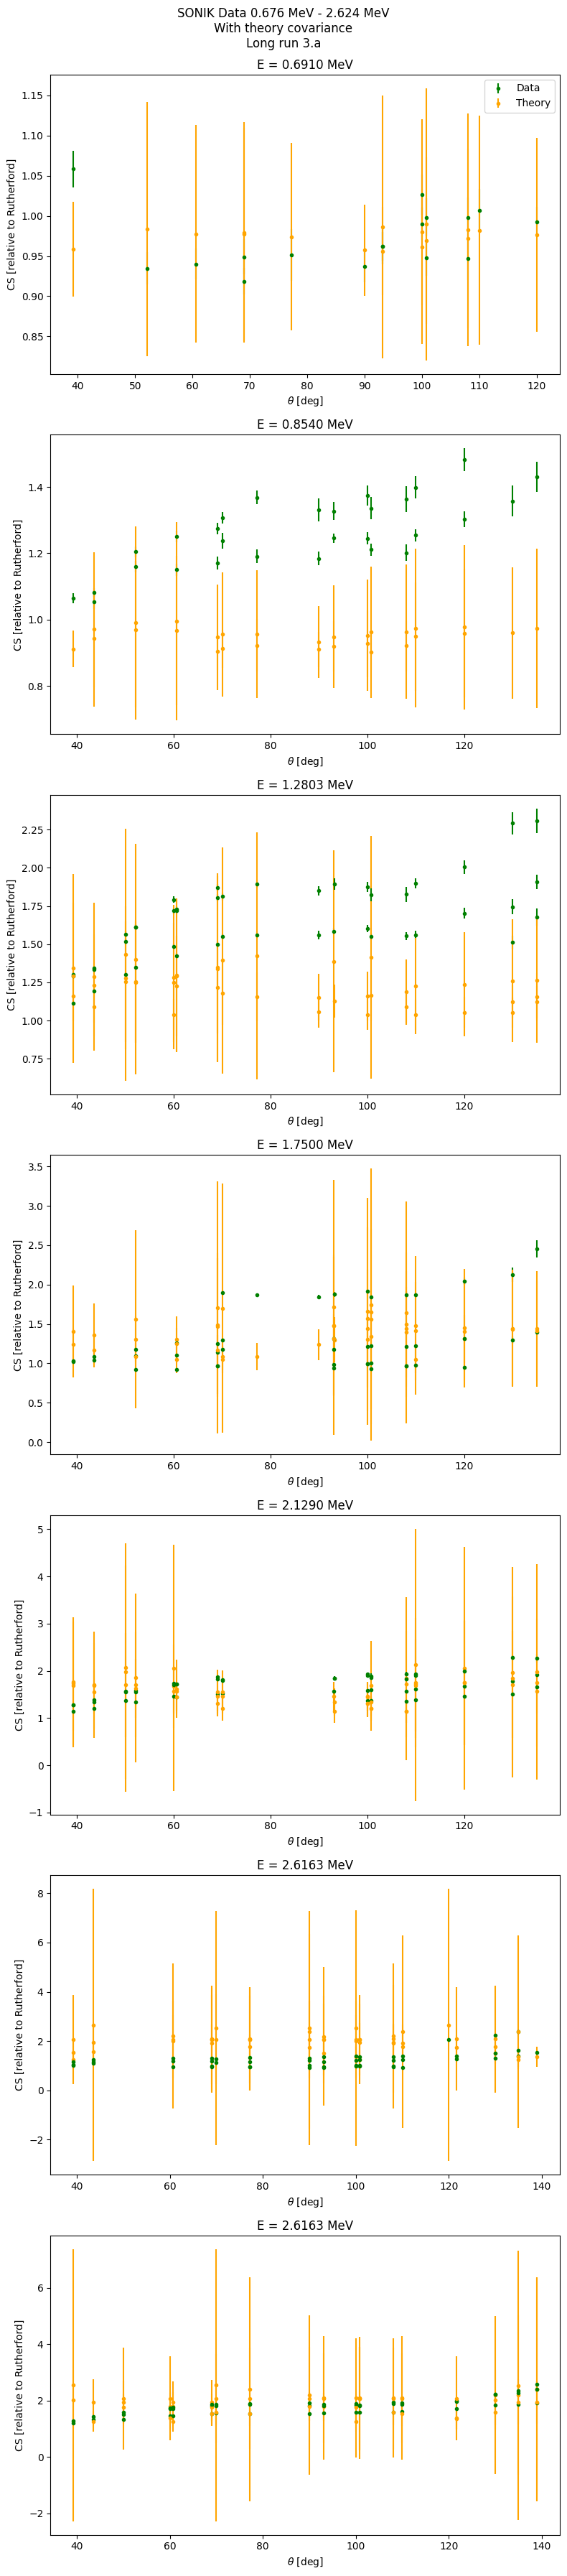

In [51]:
# Plotting energies are at the 'nominal' energies between the lowest and highest energy of the interaction regions
plotting_energy_pool = np.array([0.691, 0.854, 1.2803, 1.750, 2.129, 2.6163, 2.6163, 3.592, 4.337, 5.4797])

plot_numbers = np.where(plotting_energy_pool <= E_max)[0]

# l_som_energies = np.array([[0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 3.586, 4.332, 5.475],
#                            [0.691, 0.854, 1.28 , 1.75 , 2.129, 2.616, 3.592, 4.337, 5.48 ],
#                            [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 3.598, 4.342, 5.484]])

fig, ax = plt.subplots(plot_numbers.shape[0], 1, figsize = (8, 1 + 5 * int(plot_numbers.shape[0])))

labels_added = False

# Normalize the prediction
for i in range(0, norm_group.shape[0]):
    if not labels_added:
        ax[int(norm_group[i])].errorbar(data[i, 0], data[i, 2], yerr = data[i, 3], fmt = '.', color = 'green', label = 'Data')
        ax[int(norm_group[i])].errorbar(data[i, 0], prediction[i] * norms[int(norm_group[i])], 
                                        yerr = np.sqrt(model.cov_matrix[i, i]), fmt = '.', color = 'orange', label = 'Theory')
        labels_added = True
    else:
        ax[int(norm_group[i])].errorbar(data[i, 0], data[i, 2], yerr = data[i, 3], fmt = '.', color = 'green')
        ax[int(norm_group[i])].errorbar(data[i, 0], prediction[i] * norms[int(norm_group[i])], 
                                        yerr = np.sqrt(model.cov_matrix[i, i]), fmt = '.', color = 'orange')

if E_max >= 2.6:
    for i in range(0, int(max(norm_group)) + 1):
        ax[i].set_xlabel('$\\theta$ [deg]')
        ax[i].set_ylabel('CS [relative to Rutherford]')
        ax[i].set_title('E = {:.4f} MeV'.format(plotting_energy_pool[i]))
    else:
        for i in range(0, int(max(norm_group))):
            ax[i].set_xlabel('$\\theta$ [deg]')
            ax[i].set_ylabel('CS [relative to Rutherford]')
            ax[i].set_title('E = {:.4f} MeV'.format(plotting_energy_pool[i]))

ax[0].legend()
plt.suptitle(titles[number], y = 0.995)
plt.tight_layout()

In [47]:
parameters

array([7.90212339e+00, 7.79200355e-01, 2.37757433e-03, 7.00961064e-01,
       1.70182477e+01, 9.50867724e-01, 2.01892297e+01, 2.26993919e+00,
       9.50300571e-01, 8.99332602e-01, 1.02851097e+00, 9.81623800e-01,
       9.97598964e-01, 9.94794845e-01, 9.95413981e-01])